## What are the odds that you'll lose money on the lottery?

The code below finds the approximate odds that, after a certain number of tickets, you'll have lost money (overall) on the lottery. The code should be adaptable to any lottery, but the specific examples below focus on two popular lottery games in New York state: Mega Millions and Powerball.

The per-play odds come from [the New York Lottery's official website](http://nylottery.ny.gov/wps/portal/Home/Lottery/Home) and Durango Bill's [detailed](http://www.durangobill.com/MegaMillionsOdds.html) [explanations](http://www.durangobill.com/MegaMillionsOdds.html).

The jackpots depends on the day you're playing. But, for the sake of this analysis, the particular amount doesn't matter. But just to be safe, the analysis assumes an arbitrarily high amount of $1 billion. 

Additionally, some prizes may be split among multiple winners. ("In some cases, the fixed prizes may be paid on a pari-mutuel basis and will be lower than these published amounts," [the fine print says](http://nylottery.ny.gov/wps/portal/Home/Lottery/Home/Jackpot+Games/MEGA+MILLIONS/MegaMillions+-+Chances+of+Winning).) So, if anything, the simulated results below may understate the actual odds of becoming long-term net loser.

In [1]:
import random
import pandas as pd
import matplotlib as mpl
import seaborn as sb
%matplotlib inline

The `Lottery` class takes three parameters: The cost of a ticket, total number of possible combinations, and a list of tuples — one for each prize level. Each of these tuples takes the form, `(possible_combinations, dollars_won)`.

In [2]:
class Lottery(object):
    def __init__(self, ticket_cost, total_combinations, winning_combinations):
        self.ticket_cost = ticket_cost
        self.total_combinations = total_combinations
        self.winning_combinations = winning_combinations
        self.cutoffs = self.construct_cutoffs()
    
    def construct_cutoffs(self):
        winning_cutoffs = []
        cumulative = 0
        for n, winnings in self.winning_combinations:
            cumulative += n
            winning_cutoffs.append((cumulative, winnings))
        return winning_cutoffs
    
    def get_odds_of_winning_anything(self):
        return float(self.cutoffs[-1][0]) / self.total_combinations
    
    def play_once(self):
        rand = random.randint(1, self.total_combinations)
        for i, winnings in self.cutoffs:
            if rand <= i:
                return winnings
        return 0
    
    def play_x_times(self, x):
        return [ self.play_once() for n in range(x) ]
    
    def simulate_winnings(self, plays, players):
        return [ sum(self.play_x_times(plays))
            for _ in range(players) ]
    
    def simulate_net_loss_pct(self, plays, players):
        winnings = self.simulate_winnings(plays, players)
        loser_pct = sum(w < (plays * self.ticket_cost) for w in winnings) * 100.0 / players
        return loser_pct

## Mega Millions

- [Offical odds](http://nylottery.ny.gov/wps/portal/Home/Lottery/Home/Jackpot+Games/MEGA+MILLIONS/MegaMillions+-+Chances+of+Winning)
- [Durango Bill details](http://www.durangobill.com/MegaMillionsOdds.html)

In [3]:
mega_millions = Lottery(1, 258890850, [
    (1, 1000000000), # Hypothetical $1 billion jackpot
    (14, 1000000), # $1 million
    (350, 5000),
    (4900, 500),
    (24150, 50),
    (338100, 5),
    (547400, 5),
    (4584475, 2),
    (12103014, 1)
])

In [4]:
print("On a single Mega Millions ticket, "
      "your odds of winning anything is "
      "approximately {0:.5f}%, or 1 in {1:.2f}."\
    .format(
        mega_millions.get_odds_of_winning_anything() * 100,
        1.0 / mega_millions.get_odds_of_winning_anything()
    ))

On a single Mega Millions ticket, your odds of winning anything is approximately 6.79916%, or 1 in 14.71.


### 100,000 Mega Millions–player simulations

In [5]:
n_simulations = 1000 * 100
for n_tickets in (10, 50, 100):
    print(
        "Among 100k simulated players who each bought {0} tickets, "
        "{1:.3f}% lost money overall.".format(n_tickets, 
        mega_millions.simulate_net_loss_pct(n_tickets, n_simulations))
     )

Among 100k simulated players who each bought 10 tickets, 99.813% lost money overall.
Among 100k simulated players who each bought 50 tickets, 99.409% lost money overall.
Among 100k simulated players who each bought 100 tickets, 99.793% lost money overall.


### How *much* should you expect to lose playing Mega Millions?

The code below simulates the net profit/loss of 100,000 players who each buy one $1 Mega Millions ticket per week, for 50 weeks and for 100 weeks:

In [6]:
def plot_net_profit(lottery_name, lottery, count, simulations):
    net = pd.Series(lottery.simulate_winnings(count, simulations)) - (count * lottery.ticket_cost)
    ax = net.apply(lambda x: min(count, x)).hist(bins=range(-count * lottery.ticket_cost, count+1, 1),
        figsize=(12, 6),
        normed=True)
    ax.set_title("Net Profit/Loss After {0} Tickets — {1}"\
        .format(count, lottery_name), fontsize=18, fontweight="bold")
    ax.set_ylabel("Percentage of Simulations", fontsize=14)
    ax.set_yticks(list(pd.np.arange(0, ax.get_ylim()[-1] + 0.01, 0.01)))
    ax.set_yticklabels([ "{0:.0f}%".format(y * 100) 
        for y in ax.get_yticks() ], fontsize=12)
    ax.set_xlim((-count * lottery.ticket_cost, count))
    tick_spacing = 10 if (count * lottery.ticket_cost <= 100) else 20
    ax.set_xticks(range(-count * lottery.ticket_cost, count+1, tick_spacing))
    ax.set_xticklabels([ ("${0}" if x >= 0 else "-${0}").format(abs(x)) + ("+" if x == count else "")
        for x in ax.get_xticks() ], fontsize=12)
    mpl.pyplot.setp(ax.patches[:count * lottery.ticket_cost - 1], facecolor="darkred")
    mpl.pyplot.axvline(0, color="black", linestyle="dashed")
    return ax

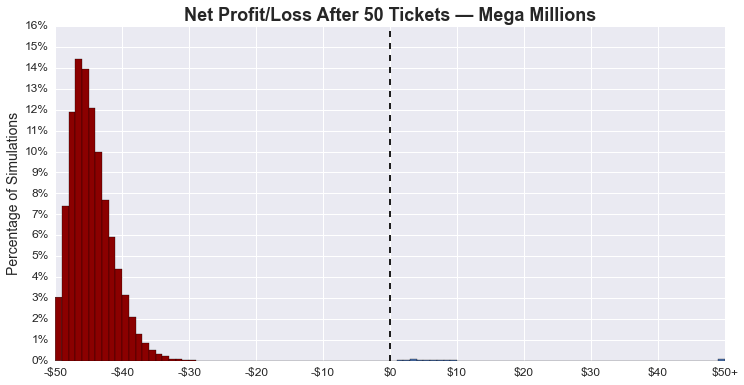

In [7]:
plot_net_profit("Mega Millions", mega_millions, 50, 100000);

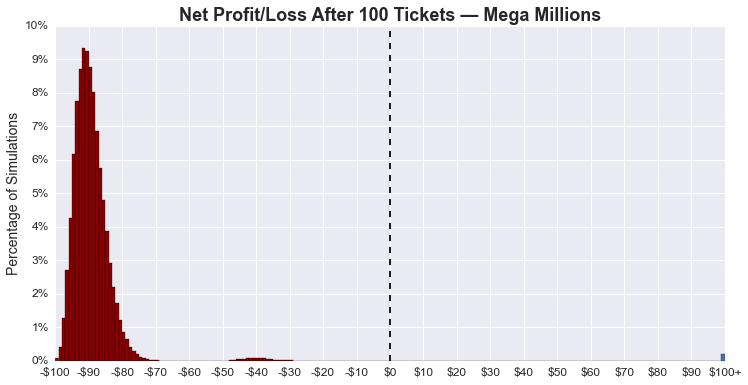

In [8]:
plot_net_profit("Mega Millions", mega_millions, 100, 100000);

## Powerball

- [Offical odds](http://nylottery.ny.gov/wps/portal/Home/Lottery/Home/Jackpot+Games/POWERBALL/Powerball+-+Chances+of+Winning)
- [Durango Bill details](http://www.durangobill.com/PowerballOdds.html)

In [9]:
powerball = Lottery(2, 292201338, [
    (1, 1000000000),
    (25, 1000000),
    (320, 50000),
    (8000, 100),
    (20160, 100),
    (504000, 7),
    (416640, 7),
    (3176880, 4),
    (7624512, 4)
])

In [10]:
print("On a single Powerball ticket, "
      "your odds of winning anything is "
      "approximately {0:.5f}%, or 1 in {1:.2f}."\
    .format(
        powerball.get_odds_of_winning_anything() * 100,
        1.0 / powerball.get_odds_of_winning_anything()
    ))

On a single Powerball ticket, your odds of winning anything is approximately 4.02138%, or 1 in 24.87.


### 100,000 Powerball–player simulations

In [11]:
n_simulations = 1000 * 100
for n_tickets in (10, 50, 100):
    print(
        "Among 100k simulated players who each bought {0} tickets, "
        "{1:.3f}% lost money overall.".format(n_tickets, 
        powerball.simulate_net_loss_pct(n_tickets, n_simulations))
     )

Among 100k simulated players who each bought 10 tickets, 99.887% lost money overall.
Among 100k simulated players who each bought 50 tickets, 99.523% lost money overall.
Among 100k simulated players who each bought 100 tickets, 99.978% lost money overall.


### How *much* should you expect to lose playing Powerball?

The code below simulates the net profit/loss of 100,000 players who each buy one $2 Powerball ticket per week, for 50 weeks and for 100 weeks:

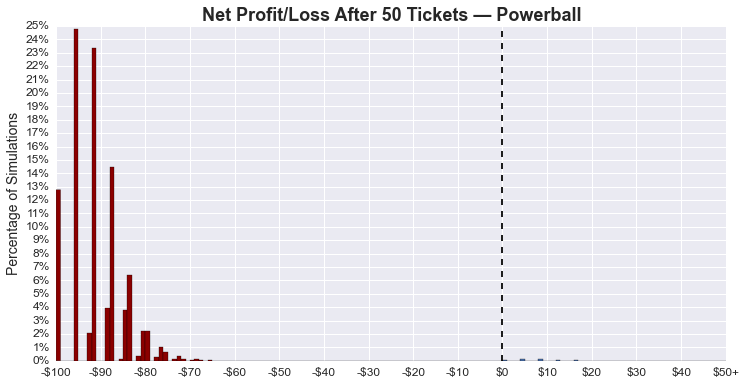

In [12]:
plot_net_profit("Powerball", powerball, 50, 100000);

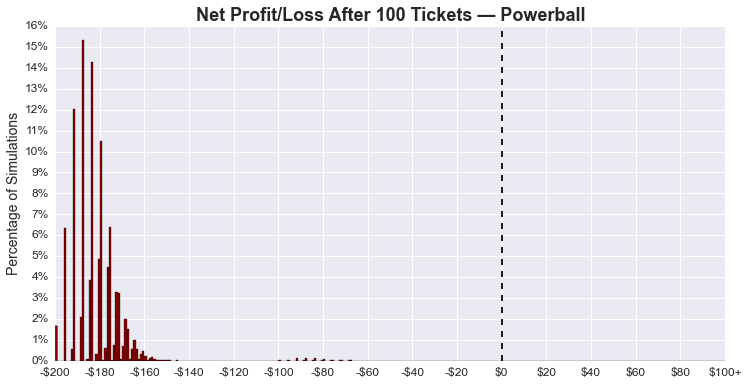

In [13]:
plot_net_profit("Powerball", powerball, 100, 100000);

---

---

---